In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [35]:
#Defining date range for historical analysis
START_DATE = datetime(2017, 1, 1)
END_DATE = datetime(2019, 12, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)

#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In [36]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    return df_fs

In [37]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2017-01-01,165,13246916
1,2017-01-02,167,13579238
2,2017-01-03,182,14405097
3,2017-01-04,177,14528908
4,2017-01-05,183,14380180
...,...,...,...
1090,2019-12-27,164,9924185
1091,2019-12-28,153,9124341
1092,2019-12-29,131,8405414
1093,2019-12-30,124,7936358


Text(0, 0.5, 'Floating Storage (t)')

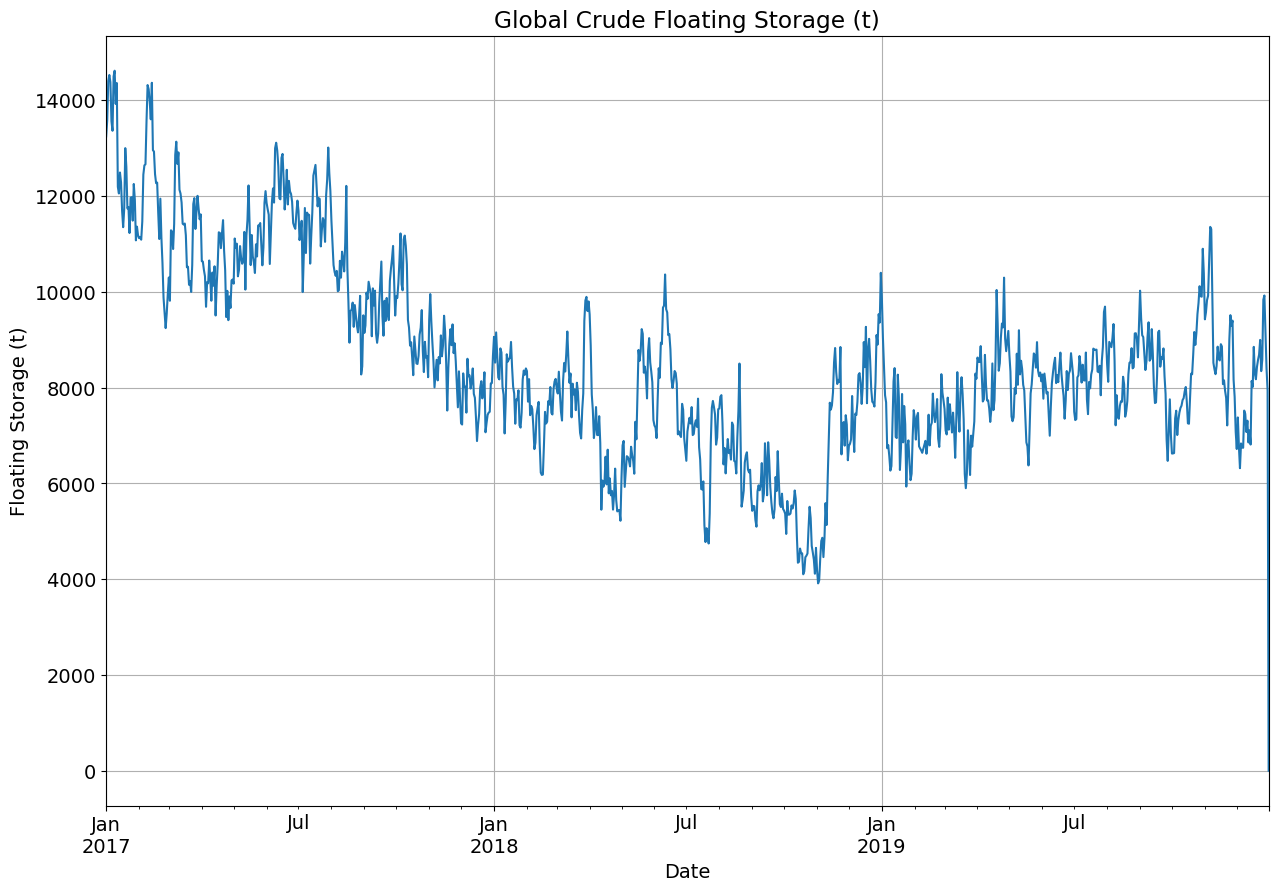

In [38]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

In [42]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
spot_prices

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2017-01-01,53.75,54.96
2017-01-02,53.75,54.96
2017-01-03,52.36,55.05
2017-01-04,53.26,54.57
2017-01-05,53.77,54.99
...,...,...
2019-12-27,61.76,68.91
2019-12-28,61.76,68.91
2019-12-29,61.76,68.91
2019-12-30,61.66,68.30


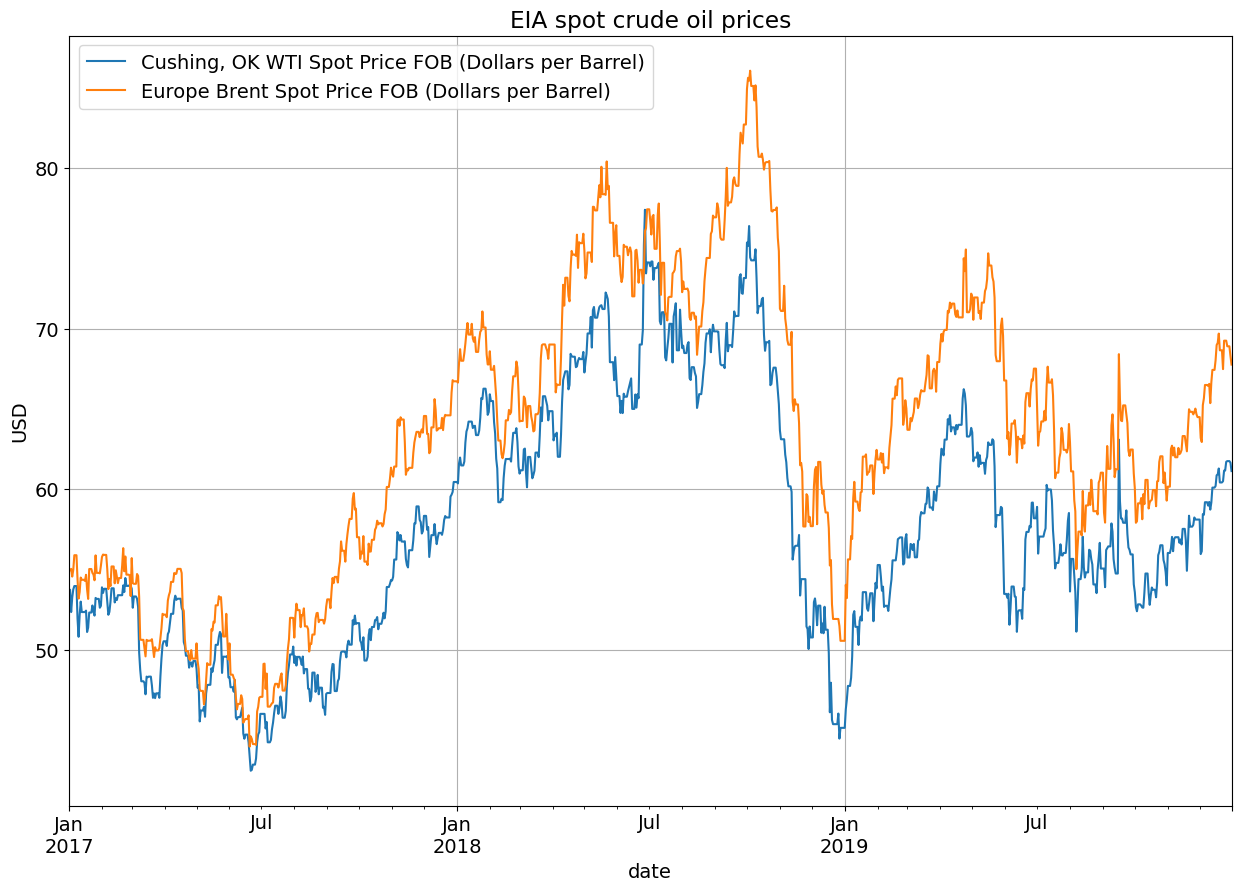

In [43]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');
#remove dates where crude oil prices are nrgative

In [17]:
spot_prices = spot_prices.iloc[:, 0]

In [18]:
future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
future_prices

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2016-01-01,37.04,38.17,39.13,39.98
2016-01-02,37.04,38.17,39.13,39.98
2016-01-03,37.04,38.17,39.13,39.98
2016-01-04,36.76,37.95,38.93,39.80
2016-01-05,35.97,37.18,38.23,39.15
...,...,...,...,...
2019-12-28,61.72,61.53,61.21,60.79
2019-12-29,61.72,61.53,61.21,60.79
2019-12-30,61.68,61.44,61.10,60.66
2019-12-31,61.06,60.77,60.41,59.97


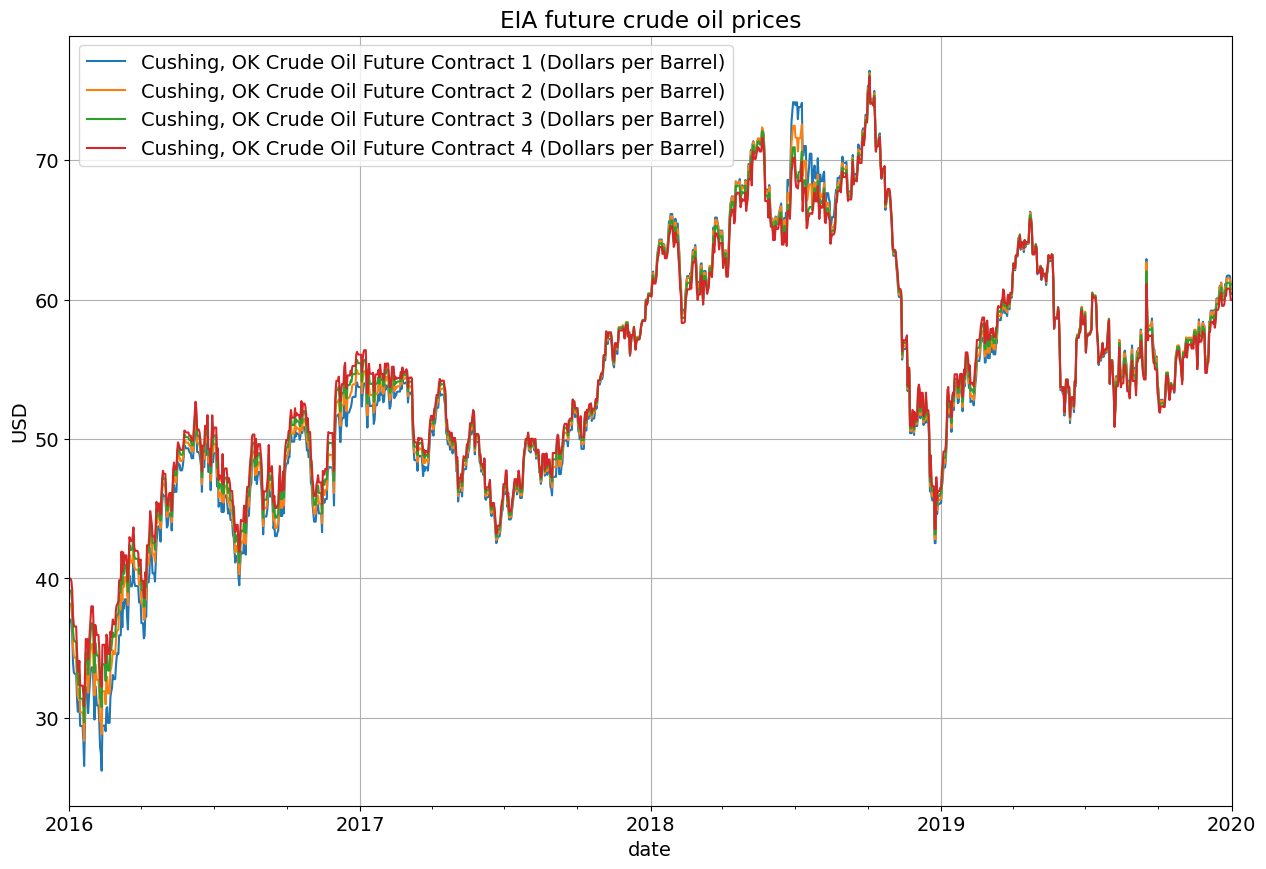

In [19]:
future_prices.plot(title='EIA future crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

In [20]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values
calendar_spread

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2016-01-01,-0.09,1.04,2.00,2.85
2016-01-02,-0.09,1.04,2.00,2.85
2016-01-03,-0.09,1.04,2.00,2.85
2016-01-04,-0.05,1.14,2.12,2.99
2016-01-05,0.00,1.21,2.26,3.18
...,...,...,...,...
2019-12-28,-0.04,-0.23,-0.55,-0.97
2019-12-29,-0.04,-0.23,-0.55,-0.97
2019-12-30,0.02,-0.22,-0.56,-1.00
2019-12-31,-0.08,-0.37,-0.73,-1.17


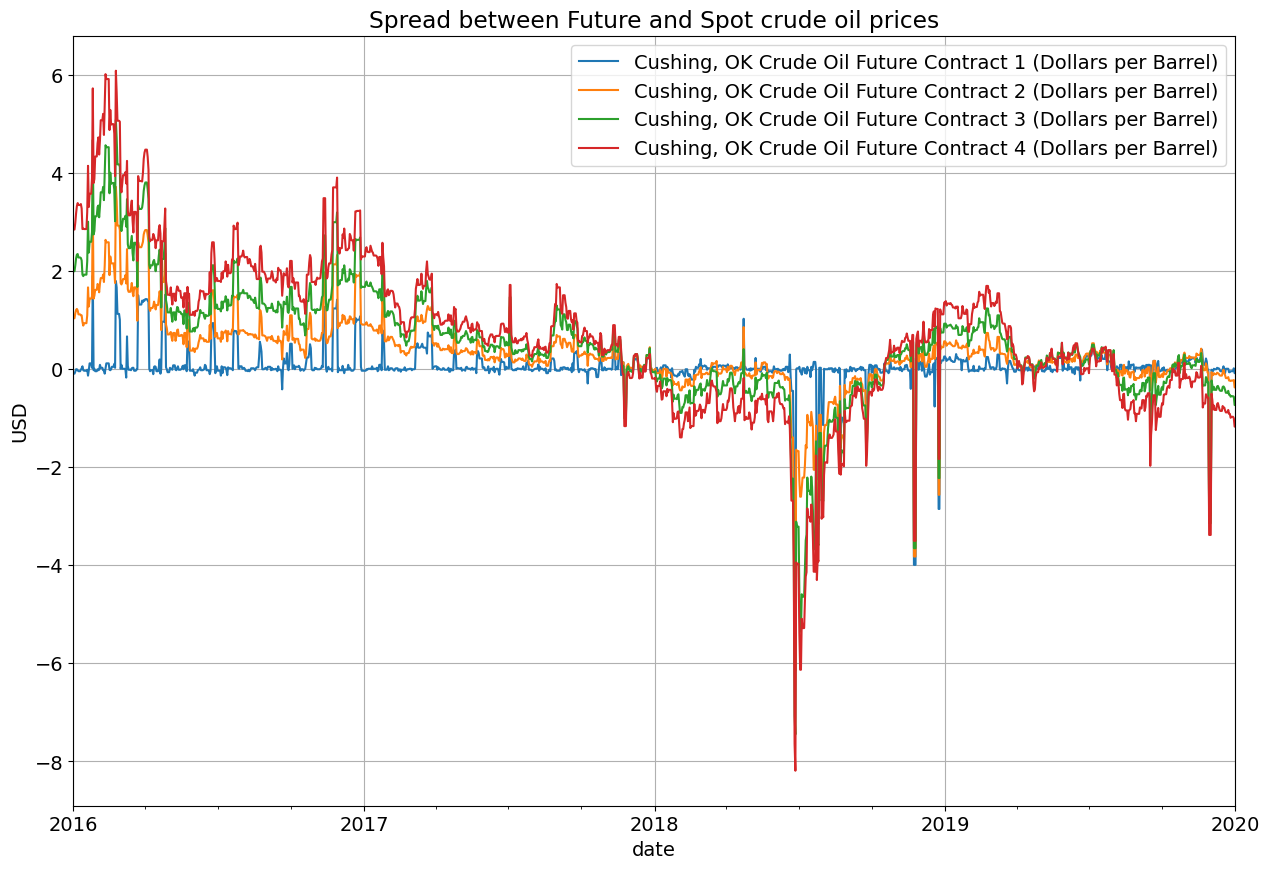

In [21]:
calendar_spread.plot(title='Spread between Future and Spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

In [22]:
future_prices = future_prices.iloc[:, 3]
calendar_spread = calendar_spread.iloc[:, 3]

In [23]:
# Maximum lag in days used for cross-correlation and Granger causality analysis
MAXLAG = 100

In [24]:
def crosscorr(series_x, series_y, lags):
    return pd.Series([series_y.corr(series_x.shift(lag)) for lag in lags], index=lags)

In [25]:
crosscorr(calendar_spread, floating_storage, lags=[0, 1])

0    0.599743
1    0.603026
dtype: float64

In [26]:
def plot_crosscorr(series_x, series_y, maxlag, label_x, label_y):
    lags = np.arange(0, maxlag+1)

    plt.subplot(211)
    xcorr_x_y = crosscorr(series_x, series_y, lags)
    xcorr_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.ylabel('correlation coeff.')

    plt.subplot(212)
    xcorr_y_x = crosscorr(series_y, series_x, lags)
    xcorr_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.xlabel('lag [days]')
    plt.ylabel('correlation coeff.')

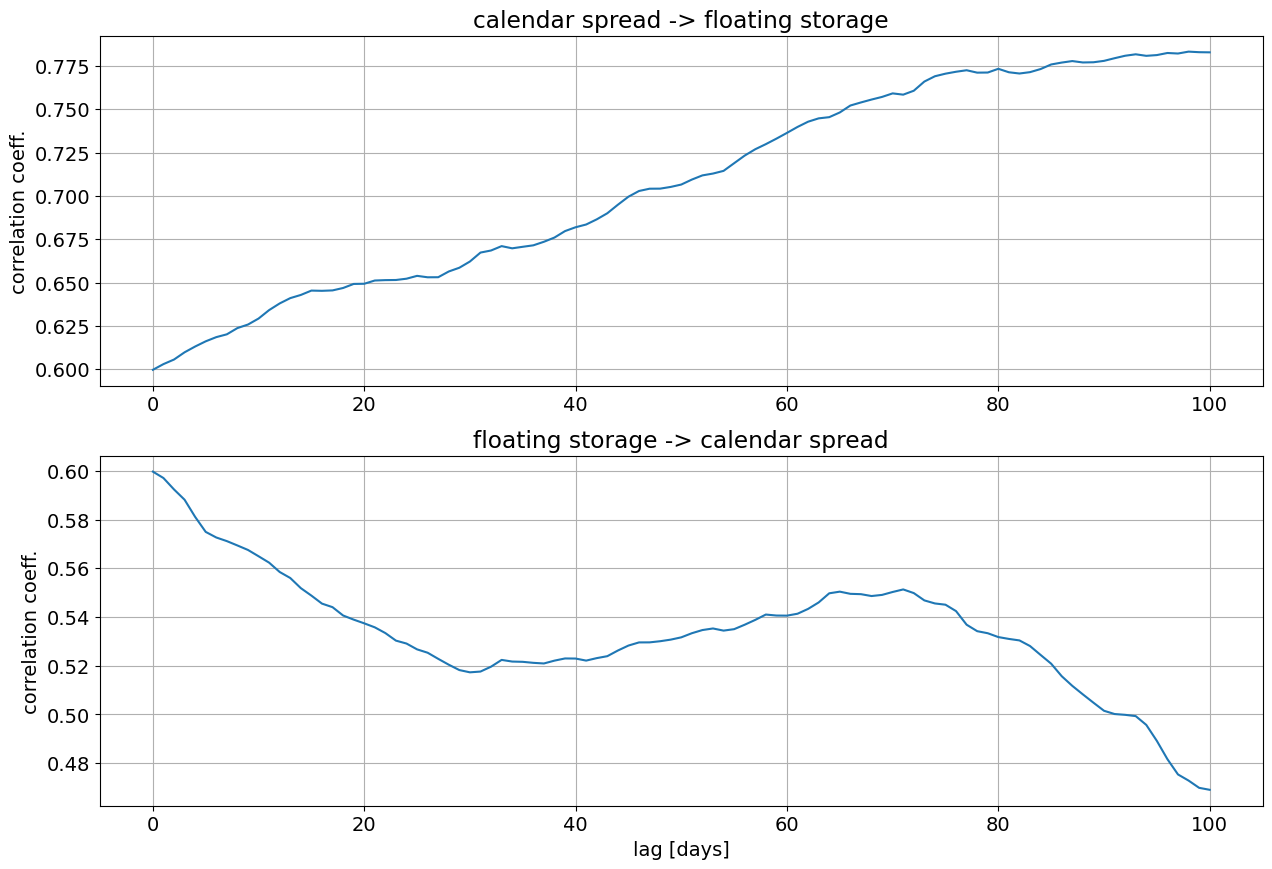

In [27]:
plot_crosscorr(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

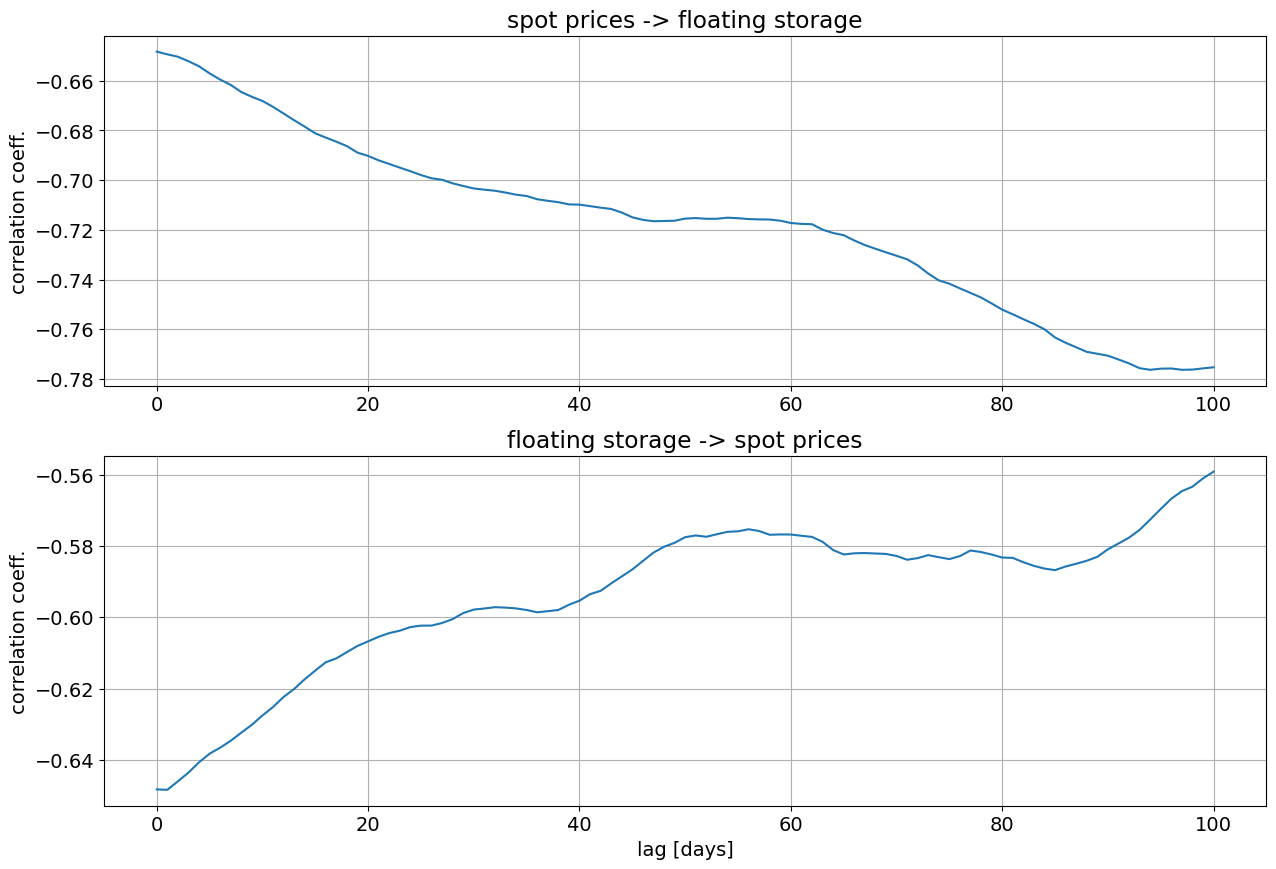

In [28]:
plot_crosscorr(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

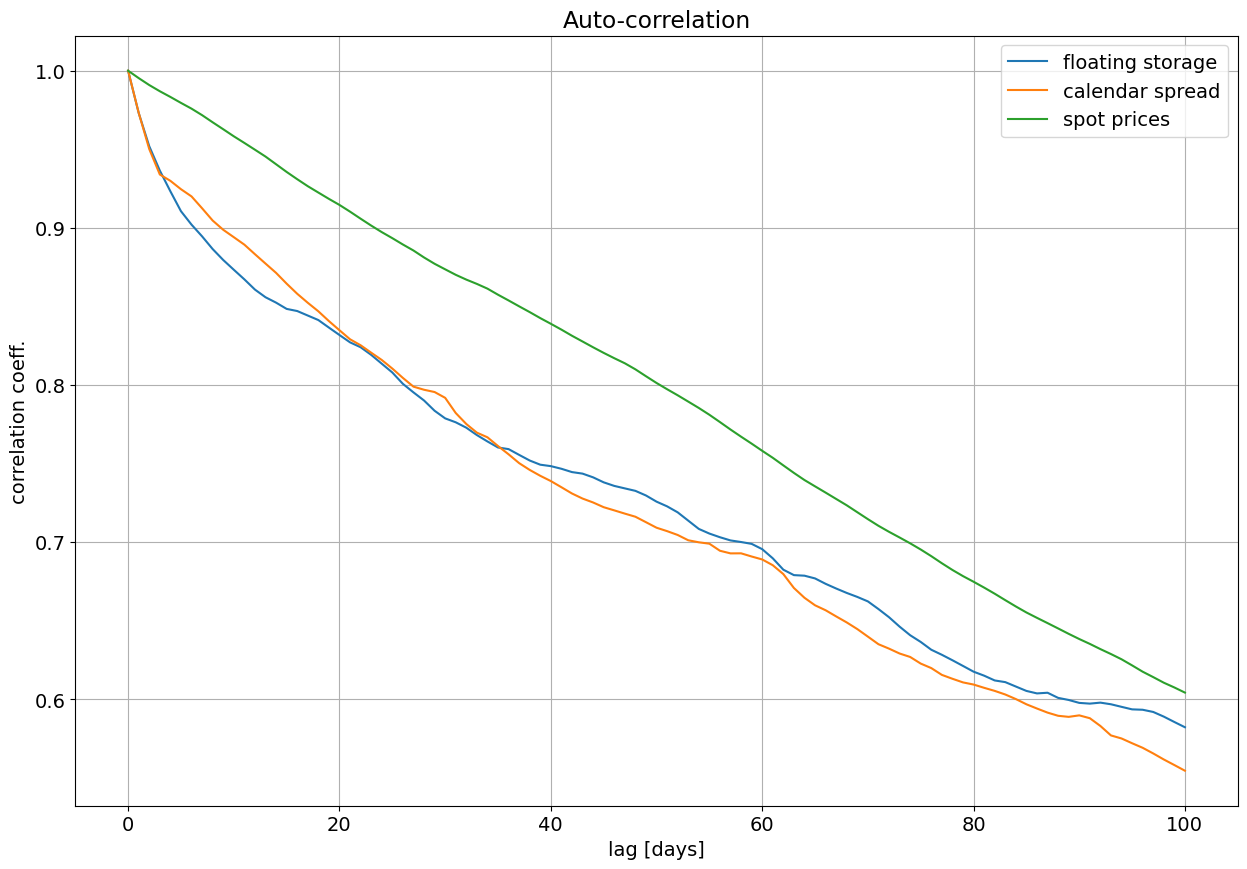

In [29]:
lags = np.arange(0, MAXLAG+1)

crosscorr(floating_storage, floating_storage, lags).plot()
crosscorr(calendar_spread, calendar_spread, lags).plot()
crosscorr(spot_prices, spot_prices, lags).plot()
plt.grid()
plt.title('Auto-correlation')
plt.legend(['floating storage', 'calendar spread', 'spot prices'])
plt.xlabel('lag [days]')
plt.ylabel('correlation coeff.');

In [30]:
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.9309 , p=0.0001  , df_denom=1458, df_num=1
ssr based chi2 test:   chi2=15.9636 , p=0.0001  , df=1
likelihood ratio test: chi2=15.8771 , p=0.0001  , df=1
parameter F test:         F=15.9309 , p=0.0001  , df_denom=1458, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7360  , p=0.0005  , df_denom=1455, df_num=2
ssr based chi2 test:   chi2=15.5252 , p=0.0004  , df=2
likelihood ratio test: chi2=15.4432 , p=0.0004  , df=2
parameter F test:         F=7.7360  , p=0.0005  , df_denom=1455, df_num=2


In [31]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot(211)
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot(212)
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')


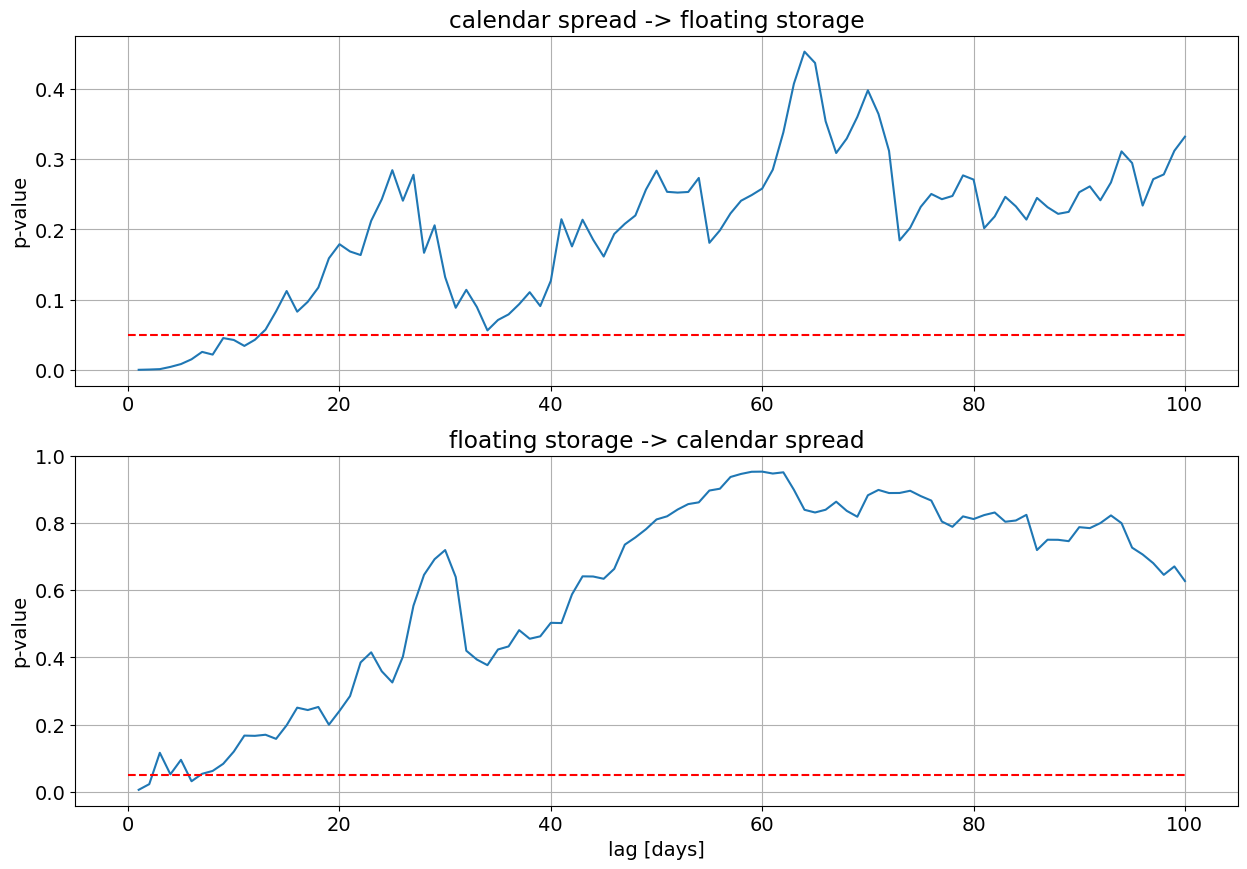

In [32]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

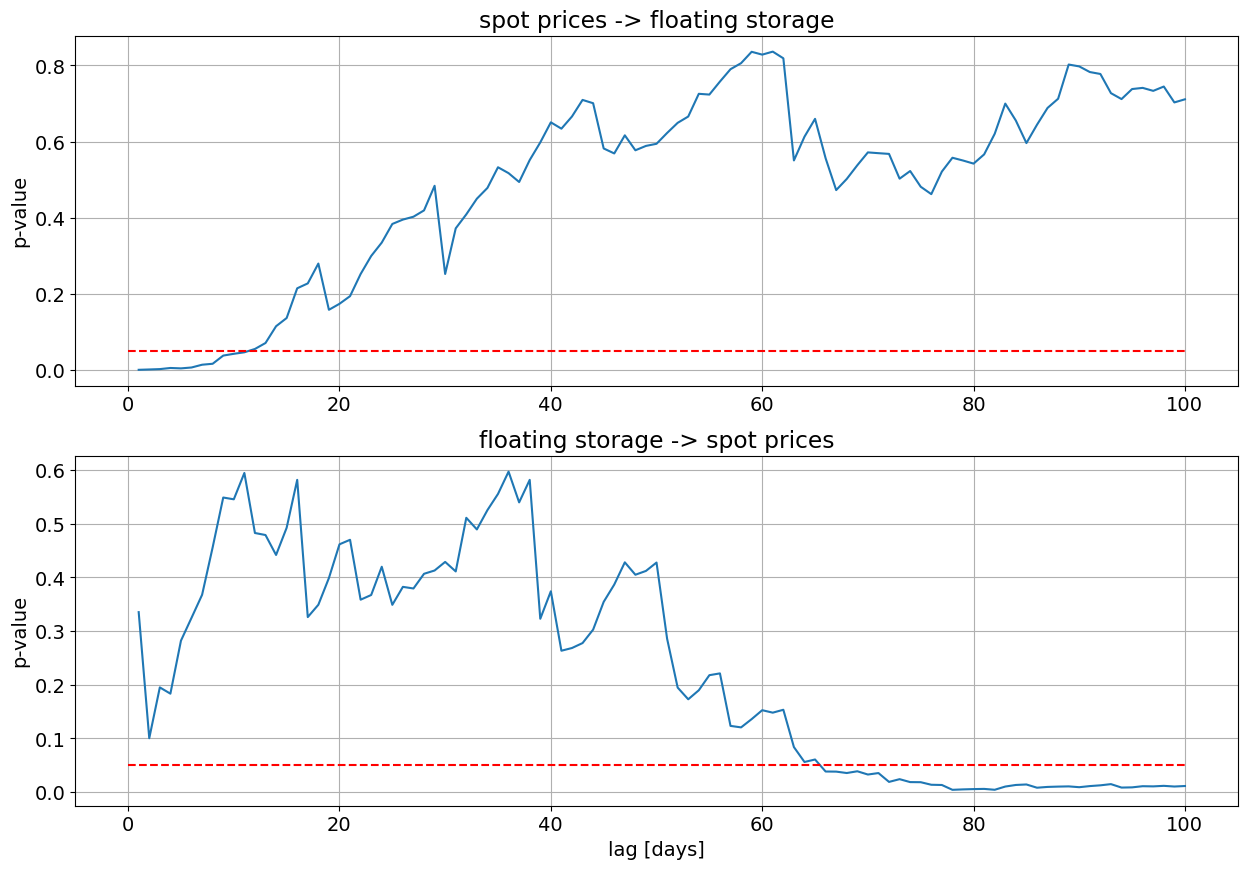

In [33]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

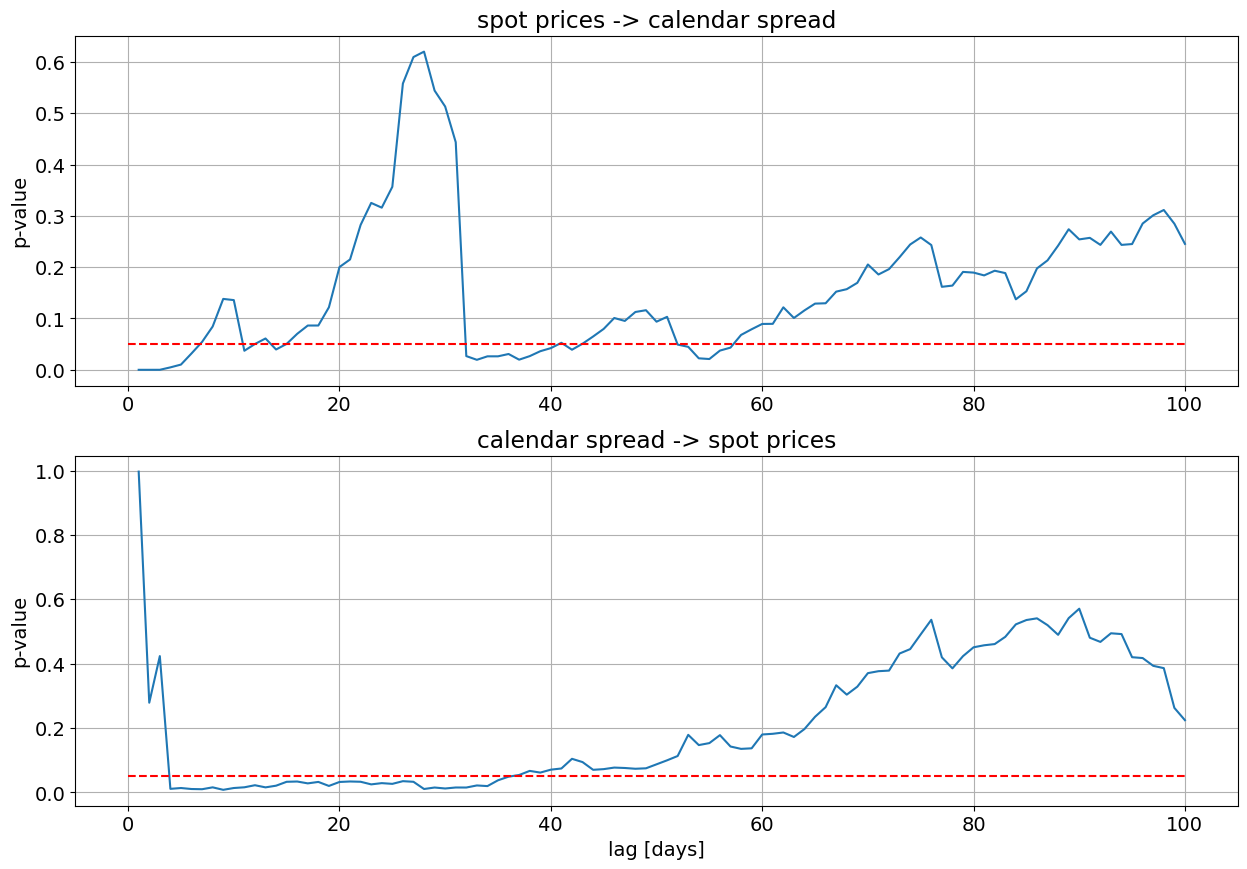

In [34]:
plot_granger_pvalues(spot_prices, calendar_spread, maxlag=MAXLAG, label_x='spot prices', label_y='calendar spread')